In [3]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split


# Load the dataset
df = pd.read_csv('Churn_Modelling.csv')

# Preprocess the data: drop irrelevant columns, encode categorical variables, handle missing values if any
df_processed = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

#encoding all categorical variables
df_processed = pd.get_dummies(df_processed)

#Using a different imputing technique
df_processed.fillna(df_processed.median(), inplace=True)  # Assuming numerical missing values for simplicity

df_processed.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42.0,2,0.00,1,1.0,1.0,101348.88,1,True,False,False,True,False
1,608,41.0,1,83807.86,1,0.0,1.0,112542.58,0,False,False,True,True,False
2,502,42.0,8,159660.80,3,1.0,0.0,113931.57,1,True,False,False,True,False
3,699,39.0,1,0.00,2,0.0,0.0,93826.63,0,True,False,False,True,False
4,850,43.0,2,125510.82,1,1.0,1.0,79084.10,0,False,False,True,True,False


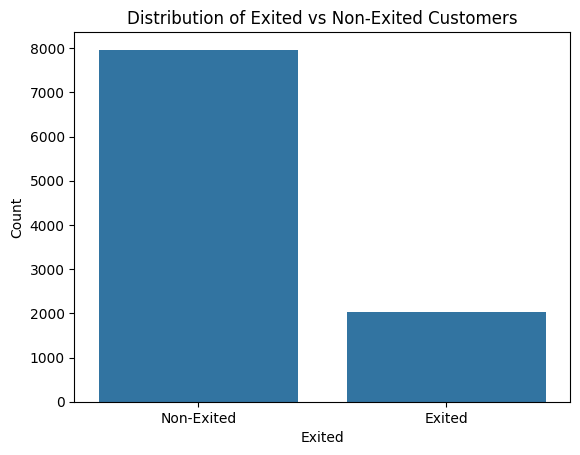

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Exited', data=df)
plt.title('Distribution of Exited vs Non-Exited Customers')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Exited', 'Exited'])
plt.show()

In [4]:
# Split the data
X = df_processed.drop('Exited', axis=1)
y = df_processed['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
from imblearn.over_sampling import SMOTE

#smote can be used to manage the imbalance in the dataset.
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    # Add more parameters here
}

#Finding parameters using different class_weights based on the histogram distribution.
grid_search = GridSearchCV(RandomForestClassifier(class_weight={0: 1, 1: 5},random_state=42), param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

#Method to train by creating a balanced dataset using SMOTE
#grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced',random_state=42), param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)
#grid_search.fit(X_train_smote, y_train_smote)

y_pred = grid_search.predict(X_test)

# Evaluate your model (e.g., using accuracy, precision, recall, F1 score)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=None,

In [19]:
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 500}


[[1445  148]
 [ 165  243]]


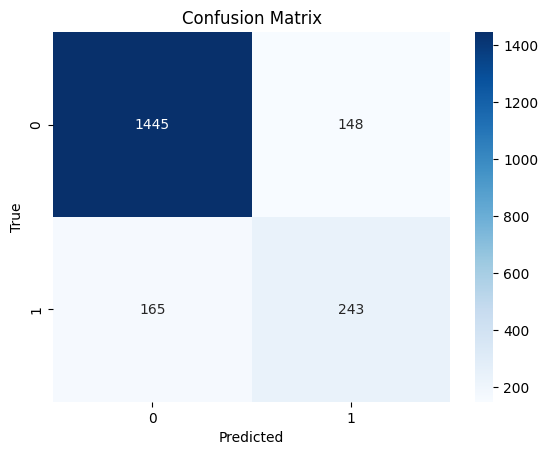

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()